# Contents

### Tune Lasso model for all numerical and categorical Ames features

[Lasso](#Lasso)

[Visualize train and test comparison](#Visualize-train-and-test-comparison)

[Visualize coefficients for varying alpha](#Visualize-coefficients-for-varying-alpha)

[Model tuning](#Model-tuning)

[Lasso with sfs](#Lasso-with-sfs)

[Summary](#Summary)

[Resources](#Resources)

[Extra](#Extra)

# Summary of previous data cleaning:

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import Lasso

In [4]:
# Import raw data, if needed for comparison
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [5]:
# Import cleaned data: ames_clean.pkl
ames = pd.read_pickle('ames_clean.pkl')

## Define datatypes

### Numerical features

In [8]:
ames.select_dtypes(include=['float64', 'int64']).head(2)

,GrLivArea,SalePrice,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,126000,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,139500,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [9]:
ames.select_dtypes(include=['float64', 'int64']).columns

Index(['GrLivArea', 'SalePrice', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

**Note:** These are the correct, 32 numerical features

In [11]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_features_list.remove('SalePrice')
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


### Categorical features

In [13]:
print(f'number of categorical features: { len(ames.select_dtypes(include=["object"]).columns) }')

number of categorical features: 48


In [14]:
ames.select_dtypes(include=["object"]).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [15]:
categorical_features = ames.select_dtypes(include=["object"])
categorical_features.head(2)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,30,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [16]:
categorical_features_list = categorical_features.columns.tolist()

In [17]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [18]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [19]:
# define features
X = ames[numerical_features_list].join(ames[categorical_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [20]:
# define target
y = ames['SalePrice']

# Lasso

[Contents](#Contents)

evaluate base model on full dataset and train-test split data to look for overfitting

In [22]:
# create storage for tuning results
tuning_results = {}

In [23]:
# numeric transformer for scaling
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# categorical transformer for encoding
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')) 
])

# define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define multiple model pipeline with preprocessor and regressor
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), ('regressor', Lasso(max_iter=20000))]
)

In [24]:
# fit model on all data for baseline
pipeline.fit(X, y)

# evaluate base model performance
scores = cross_val_score(pipeline, X, y)
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'mean-cv base model score:', round(mean_score_base_model, 4))

# refit pipeline on train-test data to look for overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score

print(f'base model train score:', round(train_score, 4))
print(f'base model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4),
    'scenario': 'base model'
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

cv scores: [0.87105663 0.92207046 0.91645864 0.92994069 0.92377107]
mean-cv base model score: 0.9127
base model train score: 0.9441
base model test score: 0.9185
base model train-test gap: 0.0256


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Visualize train and test comparison

[Contents](#Contents)

In [26]:
intercepts = []
coefs = []
scores = []
alphaRange = np.linspace(0.1,65000,20)

# fit preprocessor and transform data for lasso visualization
preprocessor_fitted = pipeline.named_steps['preprocessor'].fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)

# for later
X_test_transformed = preprocessor_fitted.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
X_train_transformed

<2064x304 sparse matrix of type '<class 'numpy.float64'>'
	with 149022 stored elements in Compressed Sparse Row format>

In [28]:
lasso_train_R2 = []
lasso_test_R2  = []
alphaRange= np.linspace(0.1,65000,20)
for alpha in alphaRange:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_transformed, y_train)   
    lasso_train_R2.append(lasso.score(X_train_transformed, y_train))
    lasso_test_R2.append(lasso.score(X_test_transformed, y_test))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276627769764.7853, tolerance: 1125382511.8355289
  model = cd_fast.sparse_enet_coordinate_descent(


In [29]:
# plt.legend?

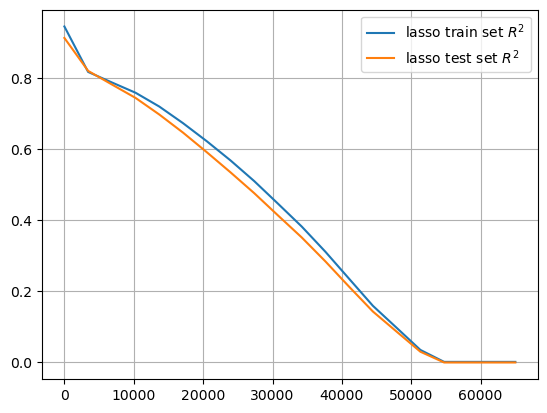

In [30]:
plt.plot(alphaRange, lasso_train_R2, label=r'lasso train set $R^2$')
plt.plot(alphaRange, lasso_test_R2, label=r'lasso test set $R^2$')
plt.legend(loc='upper right')
plt.grid()

#### zoom in on region where train and test scores converge

In [32]:
# lasso_scores_train = np.array(lasso_train_R2) 
# lasso_scores_test  = np.array(lasso_test_R2)

lasso_scores_train = []
lasso_scores_test  = []

alphas = np.linspace(0, 6000, 100)

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train_transformed, y_train)
    lasso_scores_train.append(lasso.score(X_train_transformed, y_train))
    lasso_scores_test.append(lasso.score(X_test_transformed, y_test))

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_37392/2893736507.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train_transformed, y_train)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313332633939.95874, tolerance: 1125382511.8355289
  model = cd_fast.sparse_enet_coordinate_descent(


In [33]:
# new:

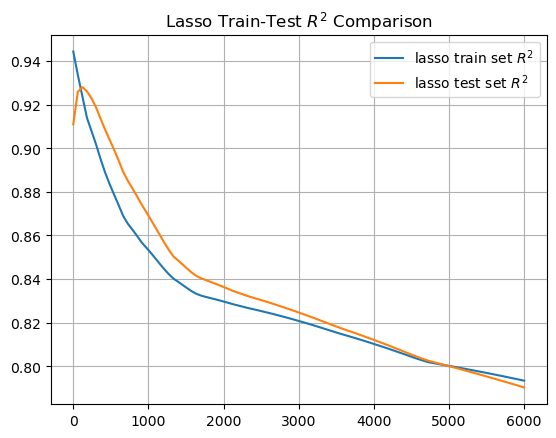

In [34]:
plt.plot(alphas, lasso_scores_train, label=r'lasso train set $R^2$')
plt.plot(alphas, lasso_scores_test, label=r'lasso test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Lasso Train-Test $R^2$ Comparison')
plt.grid()

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_37392/1248363309.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train_transformed, y_train)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313332633939.95874, tolerance: 1125382511.8355289
  model = cd_fast.sparse_enet_coordinate_descent(


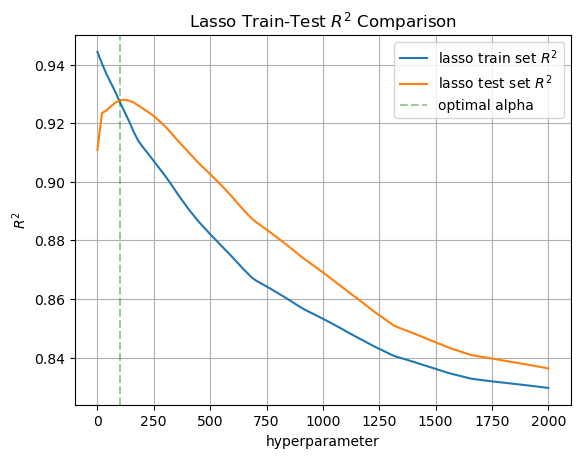

In [35]:
lasso_scores_train = []
lasso_scores_test  = []

# restrict alpha range to zoom in on first point of convergence
alphas = np.linspace(0, 2000, 100)

# get train and test scores for this range
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train_transformed, y_train)
    lasso_scores_train.append(lasso.score(X_train_transformed, y_train))
    lasso_scores_test.append(lasso.score(X_test_transformed, y_test))

# plot train-test scores for varying alpha
plt.plot(alphas, lasso_scores_train, label=r'lasso train set $R^2$')
plt.plot(alphas, lasso_scores_test, label=r'lasso test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Lasso Train-Test $R^2$ Comparison')
plt.grid()

# Convert lists to numpy arrays for element-wise subtraction
lasso_scores_train_array = np.array(lasso_scores_train)
lasso_scores_test_array = np.array(lasso_scores_test)
alphas_array = np.array(alphas)

# Find where train and test scores are closest
score_diff = np.abs(lasso_scores_train_array - lasso_scores_test_array)
optimal_idx = np.argmin(score_diff)
optimal_alpha = alphas_array[optimal_idx]

# plot line for optimal_alpha
plt.axvline(optimal_alpha, linestyle='--', color='g', label='optimal alpha', alpha=0.4)
plt.legend(loc='upper right')
plt.xlabel(r'hyperparameter')
plt.ylabel(r'$R^2$');

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_37392/588475991.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train_transformed, y_train)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313332633939.95874, tolerance: 1125382511.8355289
  model = cd_fast.sparse_enet_coordinate_descent(


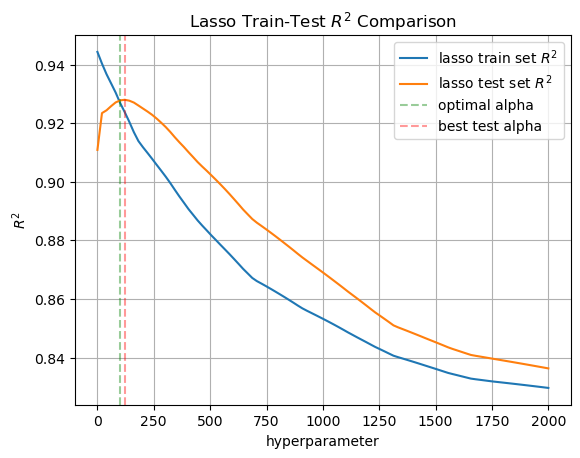

In [36]:
lasso_scores_train = []
lasso_scores_test  = []

# restrict alpha range to zoom in on first point of convergence
alphas = np.linspace(0, 2000, 100)

# get train and test scores for this range
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train_transformed, y_train)
    lasso_scores_train.append(lasso.score(X_train_transformed, y_train))
    lasso_scores_test.append(lasso.score(X_test_transformed, y_test))

# plot train-test scores for varying alpha
plt.plot(alphas, lasso_scores_train, label=r'lasso train set $R^2$')
plt.plot(alphas, lasso_scores_test, label=r'lasso test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Lasso Train-Test $R^2$ Comparison')
plt.grid()

# Convert lists to numpy arrays for element-wise subtraction
lasso_scores_train_array = np.array(lasso_scores_train)
lasso_scores_test_array = np.array(lasso_scores_test)
alphas_array = np.array(alphas)

# Find where train and test scores are closest
score_diff = np.abs(lasso_scores_train_array - lasso_scores_test_array)
optimal_idx = np.argmin(score_diff)
optimal_alpha = alphas_array[optimal_idx]

# find where test score is highest
best_test_score = np.max(lasso_scores_test_array)
best_test_idx = np.argmax(lasso_scores_test_array)
best_test_alpha = alphas_array[best_test_idx]

# plot line for optimal_alpha
plt.axvline(optimal_alpha, linestyle='--', color='g', label='optimal alpha', alpha=0.4)
plt.axvline(best_test_alpha, linestyle='--', color='r', label='best test alpha', alpha=0.4)
plt.legend(loc='upper right')
plt.xlabel(r'hyperparameter')
plt.ylabel(r'$R^2$');

In [37]:
best_test_alpha

121.2121212121212

In [38]:
optimal_alpha

101.01010101010101

? The best alpha for the model is best_test_alpha, or the alpha that gives the highest score on the testing data.

# Visualize coefficients for varying alpha

[Contents](#Contents)

In [41]:
intercepts = []
coefs = []
scores = []

alphaRange = np.linspace(0.1,6500,20)

# fit preprocessor and transform data for lasso visualization
preprocessor_fitted = pipeline.named_steps['preprocessor'].fit(X)
X_transformed = preprocessor_fitted.transform(X)

In [42]:
X_transformed

<2580x309 sparse matrix of type '<class 'numpy.float64'>'
	with 186313 stored elements in Compressed Sparse Row format>

In [43]:
# convert sparse matric to dense numpy array
X_dense_array = X_transformed.toarray()
X_dense_array

array([[-1.28959751, -0.02047921, -0.27446818, ...,  0.        ,
         1.        ,  0.        ],
       [-0.89455537, -1.27733684, -0.72429425, ...,  0.        ,
         1.        ,  0.        ],
       [-0.9928042 , -0.40720463, -0.49968889, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.05609313,  0.65629028, -0.47384389, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.72859705, -0.02047921, -0.15927332, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.86982974,  0.55960893, -0.06967732, ...,  0.        ,
         1.        ,  0.        ]])

In [44]:
feature_names = preprocessor_fitted.get_feature_names_out()
X_df = pd.DataFrame(X_dense_array, columns=feature_names)
X_df.head(2)

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_VWD,cat__SaleType_WD,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
0,-1.289598,-0.020479,-0.274468,-1.053847,-1.647539,-0.562750,-0.480748,-0.305221,0.185710,-0.431804,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.894555,-1.277337,-0.724294,0.460593,0.012109,0.286195,0.250896,1.948743,-1.023592,0.029483,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [45]:
lasso = Lasso()
for alpha in alphaRange:
    lasso.set_params(alpha=alpha)    
    lasso.fit(X_dense_array, y)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    scores.append(lasso.score(X_dense_array, y))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e+11, tolerance: 1.452e+09
  model = cd_fast.enet_coordinate_descent(


In [46]:
lasso_coefs_df = pd.DataFrame(np.array(coefs), columns=X_df.columns)
lasso_coefs_df

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_VWD,cat__SaleType_WD,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
0,35450.502735,85.567693,4566.491107,11655.026860,1271.893744,3403.629982,14623.735793,5160.695238,5581.473454,1322.094593,...,4942.356398,-7125.656889,-9445.599085,-5845.442945,1654.522805,-9089.455337,17965.237626,-13323.00823,8164.406403,29057.441049
1,29005.463989,1849.104675,3345.639780,10008.263226,5751.628229,5194.427562,7014.442016,1316.515129,-0.000000,9692.994740,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.000000,9488.881664
2,31099.637198,2162.499674,2986.458305,9219.325424,6959.443606,5918.554046,7324.580940,763.306684,-0.000000,11427.922326,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,581.458208
3,31389.505810,2196.591998,2708.787492,8883.858630,7588.294550,5772.379094,7613.880037,209.847914,-0.000000,12193.825911,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
4,31457.456598,2201.504581,2320.709190,8643.131992,8018.734366,6071.966149,7890.792962,0.000000,-0.000000,13022.855558,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
5,31161.226271,2150.904244,2073.315598,8074.863480,8336.645127,6373.567693,8211.053168,0.000000,-0.000000,13467.839146,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
6,30858.618933,1933.245917,1831.536009,7905.006080,8594.755121,6304.770442,8234.340922,0.000000,-0.000000,13372.286735,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
7,30650.618689,1679.953063,1610.463945,8030.317329,8869.652552,6163.177795,8227.735095,0.000000,-0.000000,13264.279645,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
8,30490.885660,1409.886621,1357.896640,8099.059264,9148.006937,6012.618039,8173.344390,0.000000,-0.000000,13268.159993,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000
9,30191.343218,1156.167928,1114.293837,8188.962211,9340.858659,5896.733564,8110.234799,0.000000,-0.000000,13327.155795,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,0.000000


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_37392/3079171087.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


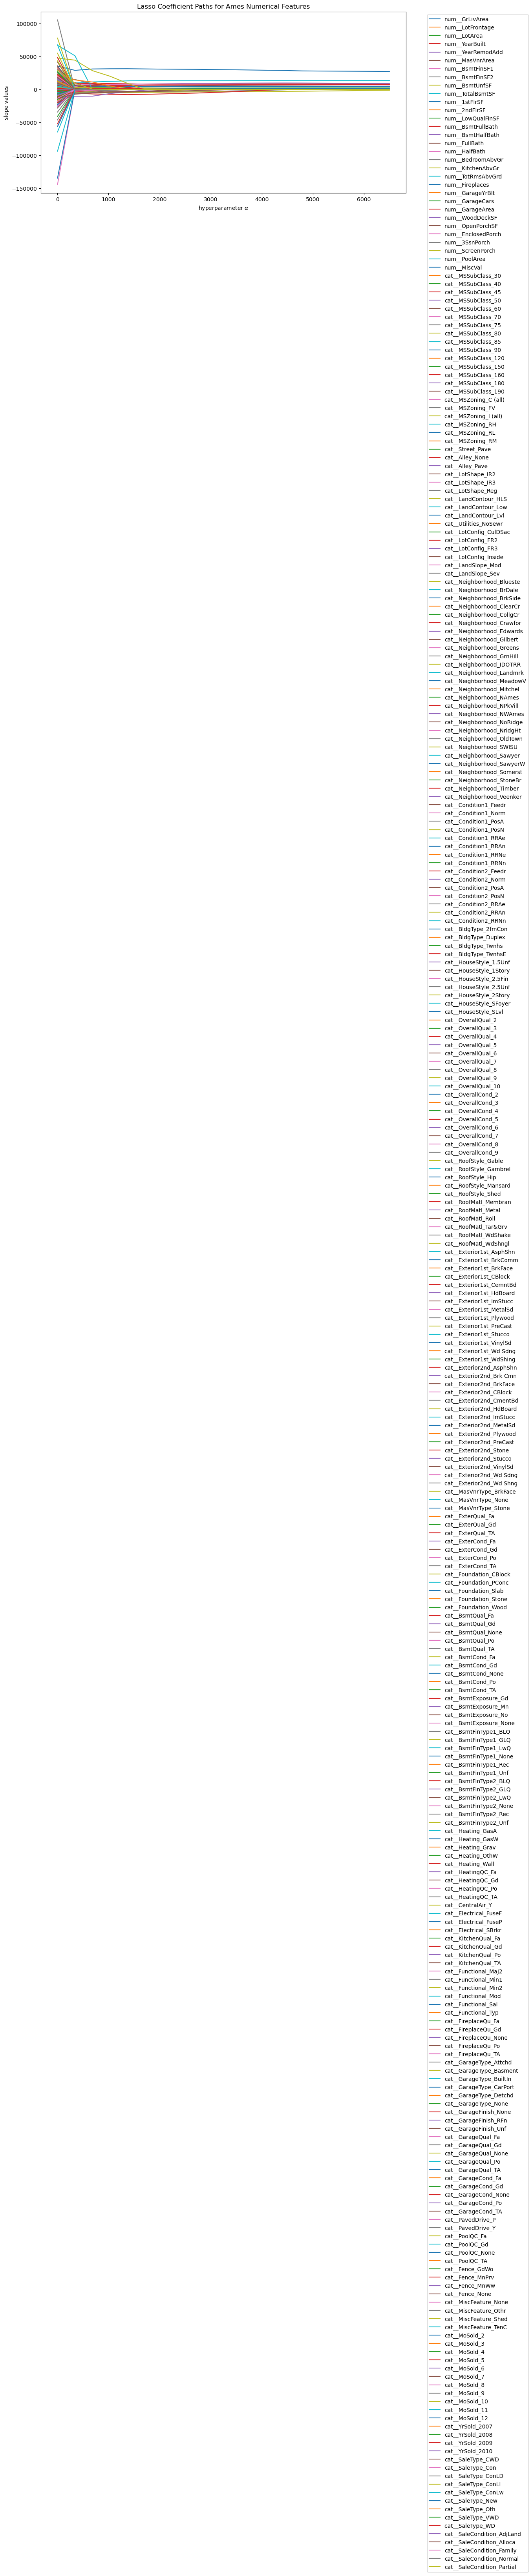

In [47]:
plt.figure(figsize=(12, 6)) 

# Visualize coefficients for varying alphas
for name in lasso_coefs_df.columns:
    plt.plot(alphaRange, lasso_coefs_df[name], label=name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'hyperparameter $\alpha$')
plt.ylabel(r'slope values')
plt.title('Lasso Coefficient Paths for Ames Numerical Features')

# Adjust layout to prevent overlapping
plt.tight_layout()     

From the linear-linear 15/12 model, the most predictive features were:

'GrLivArea',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch'

'OverallQual',
 'Neighborhood',
 'ExterQual',
 'KitchenQual',
 'BsmtQual',
 'BsmtExposure',
 'OverallCond',
 'Functional',
 'MSSubClass',
 'FireplaceQu',
 'Exterior1st',
 'Foundation'

In [49]:
(lasso_coefs_df[lasso_coefs_df.columns] == 0).sum().sort_values(ascending=True)

num__GrLivArea               0
num__GarageArea              0
num__Fireplaces              0
num__KitchenAbvGr            0
num__TotalBsmtSF             0
                            ..
cat__Exterior1st_AsphShn    19
cat__OverallCond_9          19
cat__Exterior1st_HdBoard    19
cat__Exterior2nd_PreCast    20
cat__Neighborhood_Greens    20
Length: 309, dtype: int64

In [50]:
# look at multicollinear features to see which ones are most predictive
lasso_coefs_df[[
    'num__GrLivArea', 
    'num__1stFlrSF', 
    'num__2ndFlrSF', 
    'num__LowQualFinSF', 
    'num__BsmtUnfSF', 
    'num__BsmtFinSF1', 
    'num__BsmtFinSF2', 
    'num__TotalBsmtSF'
]]

,num__GrLivArea,num__1stFlrSF,num__2ndFlrSF,num__LowQualFinSF,num__BsmtUnfSF,num__BsmtFinSF1,num__BsmtFinSF2,num__TotalBsmtSF
0,35450.502735,-8758.556119,-5346.069447,-1749.683662,5581.473454,14623.735793,5160.695238,1322.094593
1,29005.463989,0.000000,0.000000,-997.484276,-0.000000,7014.442016,1316.515129,9692.994740
2,31099.637198,0.000000,0.000000,-788.512420,-0.000000,7324.580940,763.306684,11427.922326
3,31389.505810,0.000000,0.000000,-561.567670,-0.000000,7613.880037,209.847914,12193.825911
4,31457.456598,0.000000,0.000000,-276.162209,-0.000000,7890.792962,0.000000,13022.855558
5,31161.226271,152.185180,0.000000,-0.000000,-0.000000,8211.053168,0.000000,13467.839146
6,30858.618933,511.478787,0.000000,-0.000000,-0.000000,8234.340922,0.000000,13372.286735
7,30650.618689,766.419475,0.000000,-0.000000,-0.000000,8227.735095,0.000000,13264.279645
8,30490.885660,899.387125,0.000000,-0.000000,-0.000000,8173.344390,0.000000,13268.159993
9,30191.343218,1027.288631,0.000000,-0.000000,-0.000000,8110.234799,0.000000,13327.155795


**question:** why does num__1stFlrSF swing like that? Scaling? 

In [52]:
# 0 values for select area features
features = [
    'num__GrLivArea', 
    'num__1stFlrSF', 
    'num__2ndFlrSF', 
    'num__LowQualFinSF', 
    'num__BsmtUnfSF', 
    'num__BsmtFinSF1', 
    'num__BsmtFinSF2', 
    'num__TotalBsmtSF']
zero_counts = (lasso_coefs_df[features] == 0).sum()
print(zero_counts)

num__GrLivArea        0
num__1stFlrSF         4
num__2ndFlrSF        19
num__LowQualFinSF    15
num__BsmtUnfSF       19
num__BsmtFinSF1       0
num__BsmtFinSF2      16
num__TotalBsmtSF      0
dtype: int64


Not surprisingly, 2ndFlrSF, LowQualFinSF, BsmtUnfSF and BsmtFinSF2 have little impact on the dataset (with a large number of 0 values).

The composite features are the most predictive, with 1stFlrSF and BsmtFinSF1 predictive of SalePrice. Further validation of why it was not so clear to drop the component features from the dataset, to resolve issues of multicollinearity. 

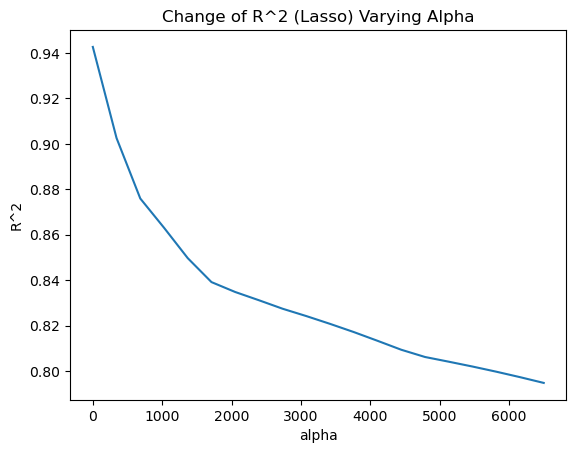

In [54]:
plt.plot(alphaRange, scores)
plt.title('Change of R^2 (Lasso) Varying Alpha')
plt.xlabel(r'alpha')
plt.ylabel(r'R^2')
plt.grid;

# Model tuning

[Contents](#Contents)

In [56]:
# run GridSearchCV on lasso to obtain optimal alpha

# define range of alpha values for lasso
alpha = list(range(1, 21, 1))  
 
# initialize Grid Search for lasso
lasso_grid_1 = GridSearchCV(estimator=pipeline,
                          param_grid={'regressor__alpha': alpha},
                          verbose=1)
 
# fit on all data for overall score
lasso_grid_1.fit(X, y)
 
# Extract the best alpha and best score
lasso_best_alpha_1 = lasso_grid_1.best_params_['regressor__alpha']
lasso_best_score_1 = lasso_grid_1.best_score_
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', lasso_best_alpha_1)
print(f'mean cv score on full dataset:', round(lasso_best_score_1,4))
print('-----------')

# check for overfitting on train-test data
lasso_grid_1.fit(X_train, y_train)
train_score = lasso_grid_1.score(X_train, y_train)
test_score = lasso_grid_1.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _1'] = {
    'mean-cv on X and y': round(lasso_best_score_1,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {lasso_best_alpha_1}'
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _1:
Evaluate model on full dataset:
model parameters: 20
mean cv score on full dataset: 0.9173
-----------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25745735494.2453, tolerance: 909180222.3963448
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zero

Check for overfitting on train-test data:
train score: 0.9404
test score: 0.9234
train-test gap: 0.0169


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [57]:
tuning_results

{'Model _0': {'mean-cv on X and y': 0.9127,
  'train score': 0.9441,
  'test score': 0.9185,
  'train-test gap': 0.0256,
  'scenario': 'base model'},
 'Model _1': {'mean-cv on X and y': 0.9173,
  'train score': 0.9404,
  'test score': 0.9234,
  'train-test gap': 0.0169,
  'scenario': 'alpha = 20'}}

This is telling me that the alpha parameter is butting up against my upper limit, maxing out the lasso penalization. The model would benefit from higher penalization. Adjust the alpha range accordingly:

In [59]:
# run GridSearchCV on lasso to obtain optimal alpha

# define range of alpha values for lasso
alpha = list(range(20, 40, 1))  # Ranges from 20 to 40 in increments of 1
 
# initialize Grid Search for lasso
lasso_grid_2 = GridSearchCV(estimator=pipeline,
                          param_grid={'regressor__alpha': alpha},
                          verbose=1)
 
# fit on all data for overall score
lasso_grid_2.fit(X, y)
 
# Extract the best alpha and best score
lasso_best_alpha_2 = lasso_grid_2.best_params_['regressor__alpha']
lasso_best_score_2 = lasso_grid_2.best_score_
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters:', lasso_best_alpha_2)
print(f'mean cv score on full dataset:', round(lasso_best_score_2,4))
print('-----------')

# check for overfitting on train-test data
lasso_grid_2.fit(X_train, y_train)
train_score = lasso_grid_2.score(X_train, y_train)
test_score = lasso_grid_2.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _2'] = {
    'mean-cv on X and y': round(lasso_best_score_2,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {lasso_best_alpha_2}'
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _2:
Evaluate model on full dataset:
model parameters: 30
mean cv score on full dataset: 0.9177
-----------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skl

Check for overfitting on train-test data:
train score: 0.937
test score: 0.9243
train-test gap: 0.0126


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Lasso with sfs

[Contents](#Contents)

In [61]:
# numeric pipeline with sequential feature selection
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator =  Lasso(max_iter=20000),
        n_features_to_select = 'auto',
        direction = 'forward',
        cv = 5,
        scoring = 'r2'
    ))
])

# categorical feature pipeline
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define multiple model pipeline with preprocessor and regressor on default params
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), ('regressor', Lasso(max_iter=20000))]
)

In [62]:
# run GridSearchCV on lasso to obtain optimal alpha

# define range of alpha values for lasso
alpha = list(range(20, 40, 1))  # Ranges from 20 to 40 in increments of 1
 
# initialize Grid Search for lasso
lasso_grid_3 = GridSearchCV(estimator=pipeline,
                          param_grid={'regressor__alpha': alpha},
                          verbose=1)
 
# fit on all data for overall score
lasso_grid_3.fit(X, y)
 
# Extract the best alpha and best score
lasso_best_alpha_3 = lasso_grid_3.best_params_['regressor__alpha']
lasso_best_score_3 = lasso_grid_3.best_score_
print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters:', lasso_best_alpha_3)
print(f'mean cv score on full dataset:', round(lasso_best_score_3,4))
print('-----------')

# check for overfitting on train-test data
lasso_grid_3.fit(X_train, y_train)
train_score = lasso_grid_3.score(X_train, y_train)
test_score = lasso_grid_3.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _3'] = {
    'mean-cv on X and y': round(lasso_best_score_3,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'sfs-reduced, alpha = {lasso_best_alpha_3}'
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _3:
Evaluate model on full dataset:
model parameters: 29
mean cv score on full dataset: 0.9167
-----------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skl

Check for overfitting on train-test data:
train score: 0.9354
test score: 0.9217
train-test gap: 0.0137


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _2,0.9177,0.937,0.9243,0.0126,alpha = 30
Model _1,0.9173,0.9404,0.9234,0.0169,alpha = 20
Model _3,0.9167,0.9354,0.9217,0.0137,"sfs-reduced, alpha = 29"
Model _0,0.9127,0.9441,0.9185,0.0256,base model


### Look at features selected by sfs for best model

In [65]:
# numeric pipeline with sequential feature selection
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator =  Lasso(max_iter=20000),
        n_features_to_select = 'auto',
        direction = 'forward',
        cv = 5,
        scoring = 'r2'
    ))
])


# categorical feature pipeline
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define pipeline with preprocessor and regressor, alpha=29
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), ('regressor', Lasso(alpha=29, max_iter=20000))]
)

In [66]:
pipeline.fit(X,y)
sfs = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['sfs']
sfs

SequentialFeatureSelector(estimator=Lasso(max_iter=20000),
                          n_features_to_select='auto', scoring='r2')

In [67]:
# get feature indices
selected_indices = sfs.get_support(indices=True)
selected_indices

array([ 0,  1,  2,  3,  4,  5,  6,  9, 17, 18, 19, 20, 23, 24, 28])

In [68]:
# get names of features selected
selected_numeric_features = [numerical_features_list[i] for i in selected_indices]
selected_numeric_features

['GrLivArea',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch']

These are the same numeric features selected by sfs in the linear model.

# Summary

[Contents](#Contents)

In [71]:
tuning_results_df
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _2,0.9177,0.937,0.9243,0.0126,alpha = 30
Model _1,0.9173,0.9404,0.9234,0.0169,alpha = 20
Model _3,0.9167,0.9354,0.9217,0.0137,"sfs-reduced, alpha = 29"
Model _0,0.9127,0.9441,0.9185,0.0256,base model


In [72]:
# save data for model comparisons
lasso_models = tuning_results_df.copy()
lasso_models['algorithm'] = 'Lasso'
lasso_models

,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
Model _0,0.9127,0.9441,0.9185,0.0256,base model,Lasso
Model _1,0.9173,0.9404,0.9234,0.0169,alpha = 20,Lasso
Model _2,0.9177,0.937,0.9243,0.0126,alpha = 30,Lasso
Model _3,0.9167,0.9354,0.9217,0.0137,"sfs-reduced, alpha = 29",Lasso


In [73]:
lasso_models.index.name = 'model'
lasso_models = lasso_models.reset_index()
lasso_models

,model,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
0,Model _0,0.9127,0.9441,0.9185,0.0256,base model,Lasso
1,Model _1,0.9173,0.9404,0.9234,0.0169,alpha = 20,Lasso
2,Model _2,0.9177,0.937,0.9243,0.0126,alpha = 30,Lasso
3,Model _3,0.9167,0.9354,0.9217,0.0137,"sfs-reduced, alpha = 29",Lasso


In [74]:
lasso_models.to_csv('lasso_models.csv')

# Resources
[Return To Top](#Contents)

**Dean De Cock paper and original data:**

- [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](https://jse.amstat.org/v19n3/decock.pdf)

- [DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

- [Ames Data Dictionary on Github](https://github.com/Padre-Media/dataset/blob/main/Ames%20Data%20Dictionary.txt)

# Extra 
[Contents](#Contents)